In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path as op

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e as CHARGE
from scipy.constants import h as PLANK
from uncertainties import ufloat

from wien2k_parse.core import Wien2kParse as w2k

GAMMA = 4.596163e7/(2*np.pi) # Hz/T
QUADMOM = 0.314e-28 # m^2

In [3]:
case = 'BaFe2As2'
head_dir = op.abspath('../data/raw/BaFe2As2_doping')
efg_site = 'As1'
magmom_site = 'Fe1'

efg_data = {}
magmom_data = {}
for pCo in ['0.02', '0.08']:
    perc_dirs = next(os.walk(op.join(head_dir, pCo, 'mag', 'mreduce')))[1]
    efg_data[pCo] = np.zeros((len(perc_dirs), 4))
    magmom_data[pCo] = np.zeros(len(perc_dirs))
    for i, perc in enumerate(perc_dirs):
        data_dir = op.join(head_dir, pCo, 'mag', 'mreduce', perc, case)
        wien = w2k(data_dir)
        efg = wien.efg(efg_site)[efg_site].gac_tensor
        magmom_data[pCo][i] = wien.magmom[magmom_site]
        eta = (efg[0, 0] - efg[2, 2])/efg[1, 1]
        efg_data[pCo][i, :] = np.array([efg[0, 0], efg[2, 2], efg[1, 1], eta])
        
pCo = '0.00'
perc_dirs = next(os.walk(op.join(head_dir, pCo, 'mreduce')))[1]
efg_data[pCo] = np.zeros((len(perc_dirs), 4))
magmom_data[pCo] = np.zeros(len(perc_dirs))
for i, perc in enumerate(perc_dirs):
    data_dir = op.join(head_dir, pCo, 'mreduce', perc, case)
    wien = w2k(data_dir)
    efg = wien.efg(efg_site)[efg_site].gac_tensor
    magmom_data[pCo][i] = wien.magmom[magmom_site]
    eta = (efg[0, 0] - efg[2, 2])/efg[1, 1]
    efg_data[pCo][i, :] = np.array([efg[0, 0], efg[2, 2], efg[1, 1], eta])

In [4]:
NUC_EXP = {'0.00': ufloat(2.22, 0.03), # 10K
           '0.08': ufloat(2.21, 0.01) # 50K
          }
ETA_EXP = {'0.00': ufloat(1.18, 0.06), # 10K
           '0.08': ufloat(0.114, 0.001) # 50K
          }
MAGMOM_EXP = {'0.00': ufloat(0.87, 0.03) # 5K
             }

In [5]:
nuc = NUC_EXP['0.00'].n*1e6
eta = ETA_EXP['0.00'].n
Vcc = 2*PLANK*nuc/(CHARGE*QUADMOM)
Vaa = -Vcc/2*(1 + eta)
Vbb = Vcc/2*(-1 + eta)
Vaa/1e21, Vbb/1e21, Vcc/1e21

def get_efg(nuc, eta):
    Vcc = 2*PLANK*nuc*1e6/(CHARGE*QUADMOM)
    Vaa = -Vcc/2*(1 + eta)
    Vbb = Vcc/2*(-1 + eta)
    
    return Vaa, Vbb, Vcc

(-6.374196619755638e+20+/-1.9544237344023548e+19, 5.263098126403737e+19+/-1.7558071316286302e+19, 5.8478868071152655e+20+/-7.902549739344952e+18, 0.87+/-0.03)


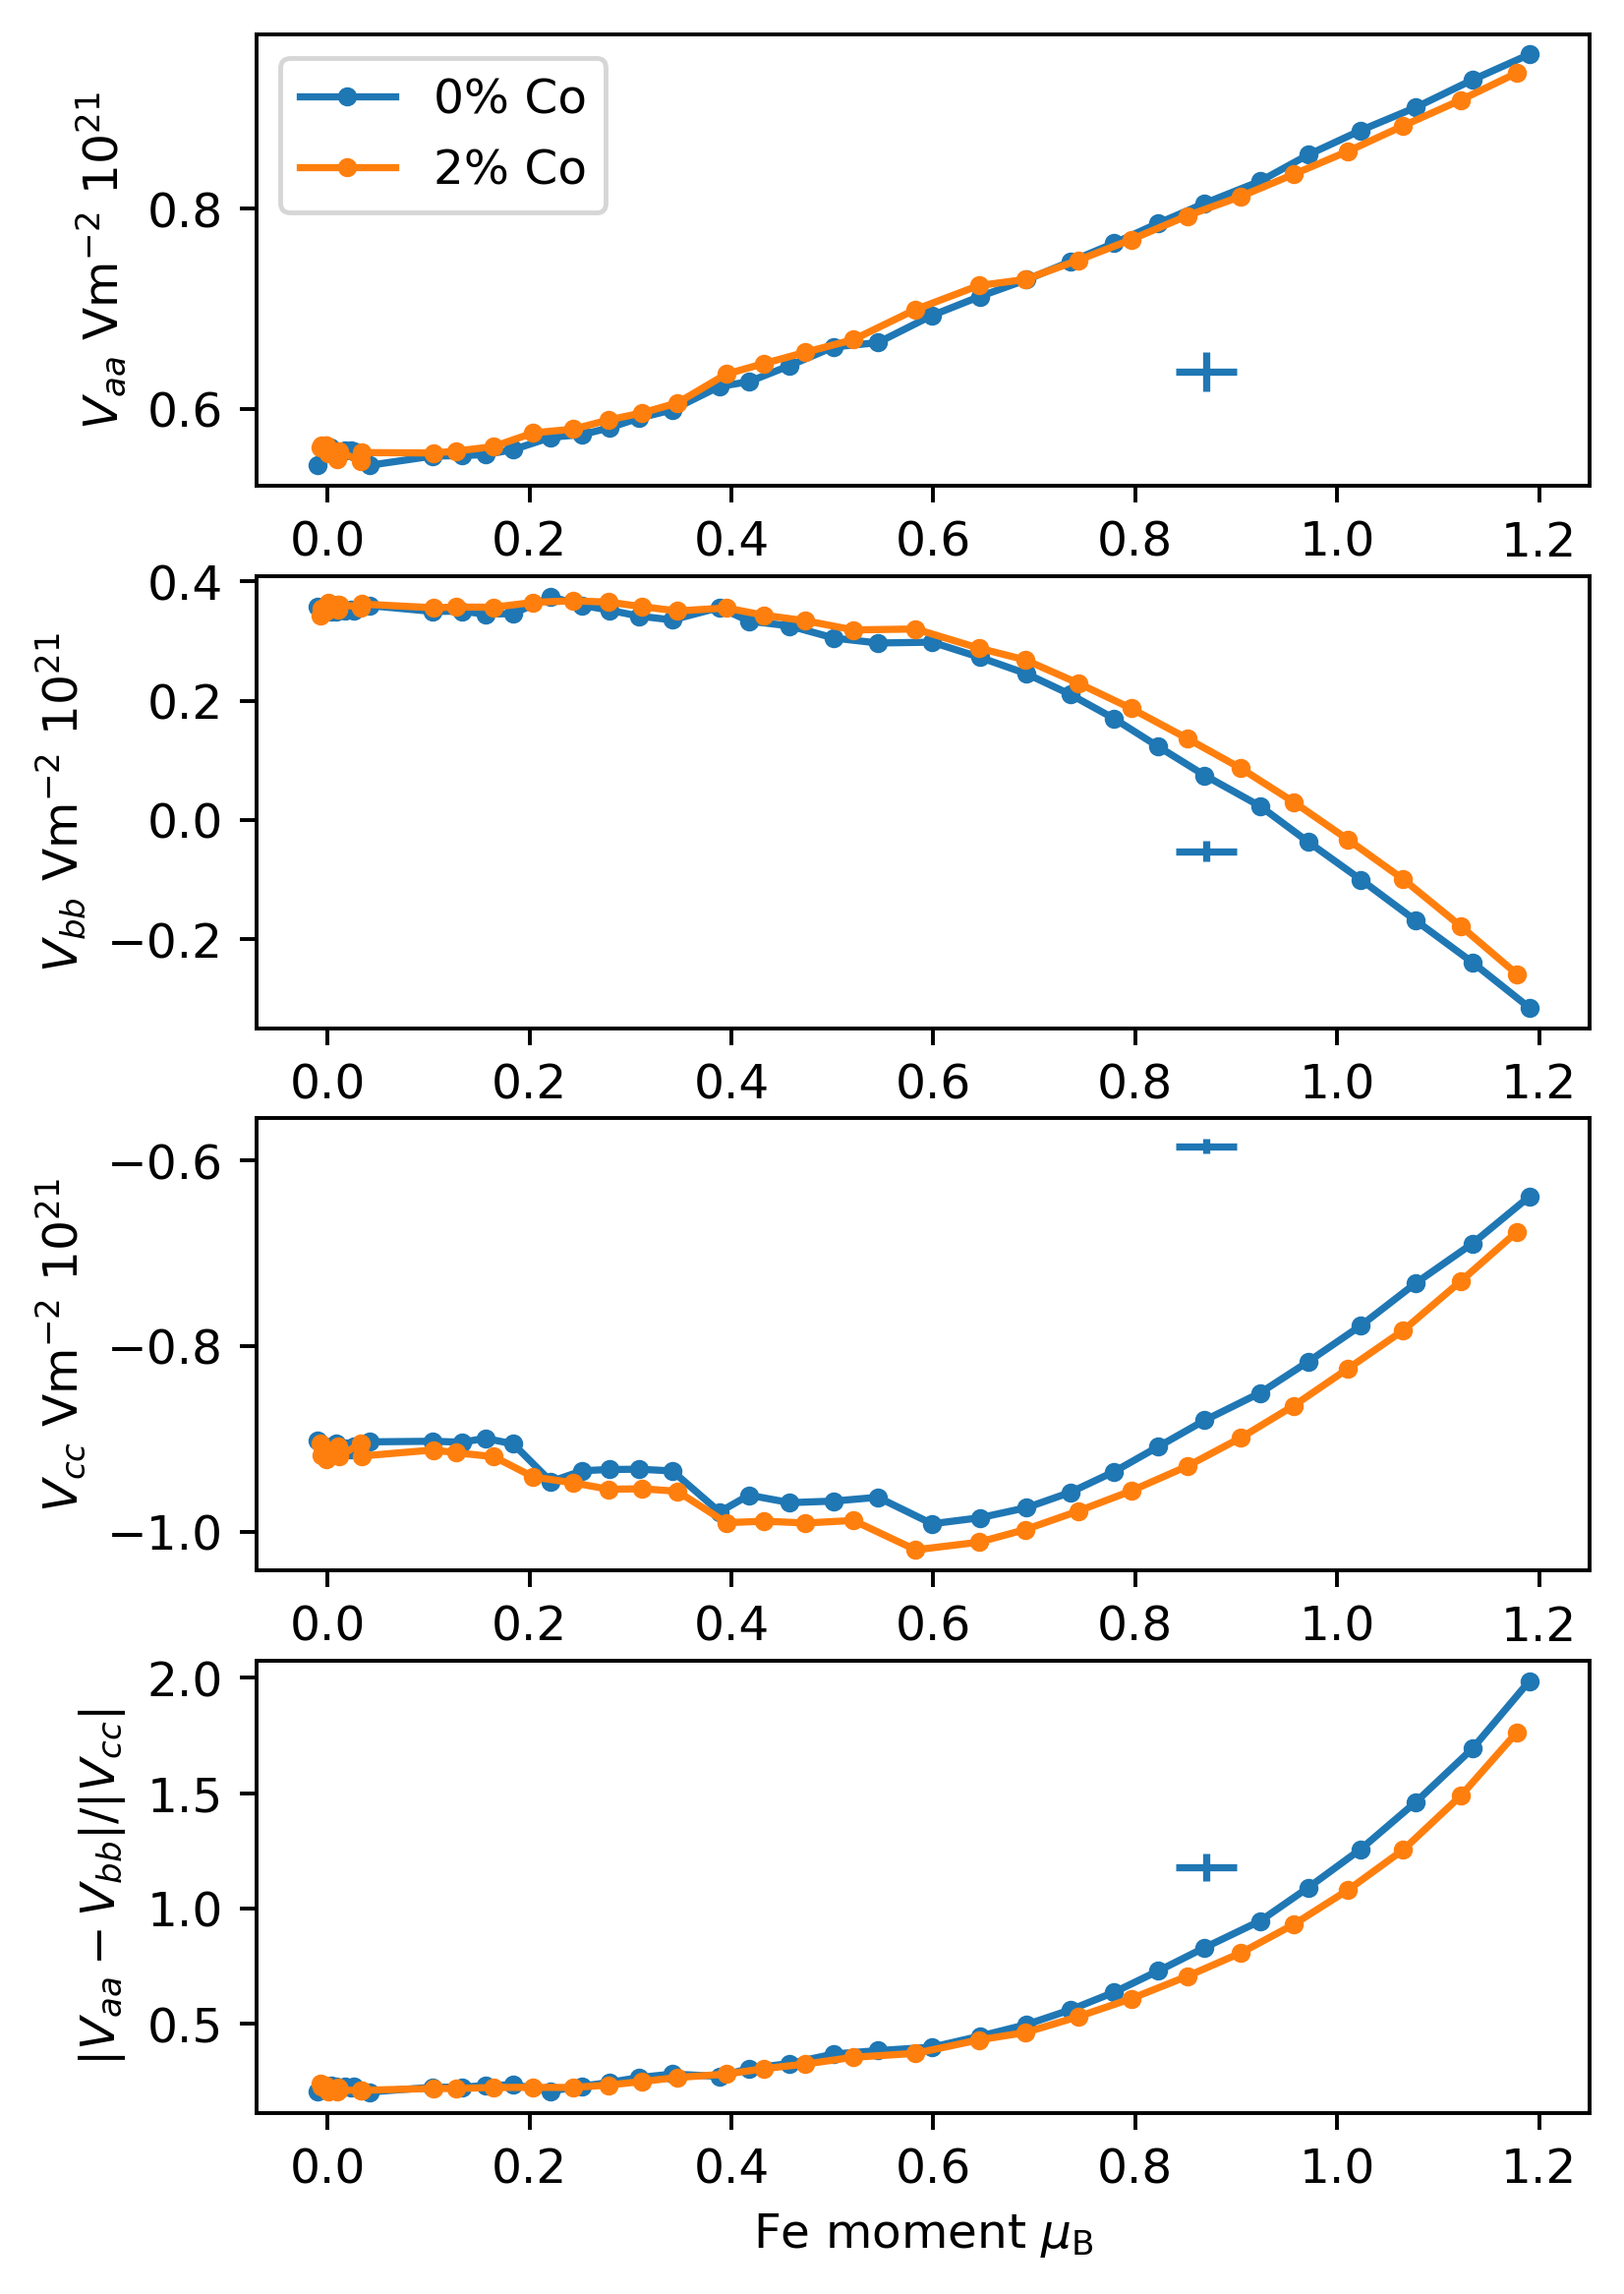

In [7]:
fig, axs = plt.subplots(4, dpi=350, figsize=(5, 8))
labels = {'0.02': '2% Co', '0.08': '8% Co', '0.00': '0% Co'}
pCos = ['0.00', '0.02']
for pCo in pCos:
    order = np.argsort(magmom_data[pCo])
    magmom = magmom_data[pCo][order]
    Vaa = efg_data[pCo][:, 0][order]/1e21
    Vbb = efg_data[pCo][:, 1][order]/1e21
    Vcc = efg_data[pCo][:, 2][order]/1e21
    eta = np.abs(Vaa - Vbb)/np.abs(Vcc)#efg_data[pCo][:, 3][order]
#    plt.plot(magmom, Vaa)
#    plt.plot(magmom, Vbb)
    axs[0].plot(magmom[0:35], Vaa[0:35], '.-', label=labels[pCo])
    axs[1].plot(magmom[0:35], Vbb[0:35], '.-', label=labels[pCo])
    axs[2].plot(magmom[0:35], Vcc[0:35], '.-', label=labels[pCo])
    axs[3].plot(magmom[0:35], eta[0:35], '.-', label=labels[pCo])
    #plt.plot(magmom, eta)
    
exp = {'0.00': get_efg(NUC_EXP['0.00'], ETA_EXP['0.00']) + (MAGMOM_EXP['0.00'], ),
       '0.08': get_efg(NUC_EXP['0.08'], ETA_EXP['0.08']) + (None, )
      }
magmom = exp['0.00'][-1]
Vaa, Vbb, Vcc = exp['0.00'][0:-1]
eta = np.abs(Vaa - Vbb)/np.abs(Vcc)
axs[0].errorbar(magmom.n, -Vaa.n/1e21, fmt='', color = axs[0].lines[0].get_color(), xerr=magmom.s, yerr=Vaa.s/1e21)
axs[1].errorbar(magmom.n, -Vbb.n/1e21, fmt='', color = axs[1].lines[0].get_color(), xerr=magmom.s, yerr=Vbb.s/1e21)
axs[2].errorbar(magmom.n, -Vcc.n/1e21, fmt='', color = axs[1].lines[0].get_color(), xerr=magmom.s, yerr=Vcc.s/1e21)
axs[3].errorbar(magmom.n, eta.n, fmt='', color = axs[1].lines[0].get_color(), xerr=magmom.s, yerr=eta.s)

# Vaa, Vbb, Vcc = exp['0.08'][0:-1]
# eta = np.abs(Vbb - Vaa)/np.abs(Vcc)
# axs[0].axhline(-Vaa.n/1e21, ls='-', lw='1', color = axs[0].lines[2].get_color())#, xerr=magmom.s, yerr=Vaa.s/1e21)
# axs[1].axhline(-Vbb.n/1e21, ls='-', lw='1', color = axs[1].lines[2].get_color())#, xerr=magmom.s, yerr=Vaa.s/1e21)
# axs[2].axhline(-Vcc.n/1e21, ls='-', lw='1', color = axs[2].lines[2].get_color())#, xerr=magmom.s, yerr=Vaa.s/1e21)
# axs[3].axhline(eta.n, ls='-', lw='1', color = axs[3].lines[2].get_color())#, xerr=magmom.s, yerr=Vaa.s/1e21)

axs[0].set_ylabel(r'$ V_{aa}$ Vm$^{-2}$ 10$^{21}$')
axs[1].set_ylabel(r'$ V_{bb}$ Vm$^{-2}$ 10$^{21}$')
axs[2].set_ylabel(r'$ V_{cc}$ Vm$^{-2}$ 10$^{21}$')
axs[3].set_ylabel(r'$ |V_{aa} - V_{bb}|/|V_{cc}| $')
axs[3].set_xlabel(r'Fe moment $ \mu_\mathrm{B} $')
axs[0].legend()
print(exp['0.00'])